In [1]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split



2025-08-14 11:57:01.550996: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-14 11:57:01.571292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-14 11:57:01.582927: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-14 11:57:01.586581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-14 11:57:01.594928: I tensorflow/core/platform/cpu_feature_guar

In [3]:
# Dataset Paths
train_dir = '/home/silver/Pneumonia-Detection-using-CNN/data/chest_xray/chest_xray/train'
test_dir = '/home/silver/Pneumonia-Detection-using-CNN/data/chest_xray/chest_xray/test'
val_dir = '/home/silver/Pneumonia-Detection-using-CNN/data/chest_xray/chest_xray/val'
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                resized_arr = resized_arr.reshape((img_size, img_size, 1))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)
# Loading training, testing, and validation data
train = get_training_data(train_dir)
test = get_training_data(test_dir)
val = get_training_data(val_dir)

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'

OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



In [4]:
from collections import Counter

# Extract labels
train_labels = [label for _, label in train]
val_labels = [label for _, label in val]

# Count occurrences
train_dist = Counter(train_labels)
val_dist = Counter(val_labels)

# Print label distribution
print("Training set label distribution:")
for label, count in train_dist.items():
    print(f"{labels[label]}: {count}")

print("\nValidation set label distribution:")
for label, count in val_dist.items():
    print(f"{labels[label]}: {count}")


Training set label distribution:
PNEUMONIA: 3875
NORMAL: 1341

Validation set label distribution:
PNEUMONIA: 8
NORMAL: 8


In [8]:
# Prepare data for training
x_train, y_train = [], []
x_test, y_test = [], []
x_val, y_val = [], []
for feature, label in train:
    x_train.append(feature)
    y_train.append(label)
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)
# Normalize data
x_train = np.array(x_train) / 255.0
x_test = np.array(x_test) / 255.0
x_val = np.array(x_val) / 255.0
# Reshape for CNN (Add channel dimension for grayscale)
x_train = x_train.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

In [9]:
# Data Augmentation for CNN
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

In [10]:
# CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D(2,2),
    Conv2D(256, (3,3), activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPool2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/home/silver/Pneumonia-Detection-using-CNN/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1755169319.195998   20150 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-08-14 12:01:59.677832: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup th

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 72, 72, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 5, 5, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 558,273 (2.13 MB)

 Trainable params: 557,185 (2.13 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [11]:
# Reduce Learning Rate on Plateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.3, min_lr=0.000001)
# Fit CNN model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=12,
    validation_data=(x_val, y_val),
    callbacks=[learning_rate_reduction]
)

Epoch 1/12


/home/silver/Pneumonia-Detection-using-CNN/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 350ms/step - accuracy: 0.8499 - loss: 0.3698 - val_accuracy: 0.5000 - val_loss: 10.5235 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 59s 359ms/step - accuracy: 0.8919 - loss: 0.2692 - val_accuracy: 0.5000 - val_loss: 15.6353 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 61s 377ms/step - accuracy: 0.9185 - loss: 0.2157 - val_accuracy: 0.5000 - val_loss: 9.9897 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 58s 352ms/step - accuracy: 0.9385 - loss: 0.1634 - val_accuracy: 0.5625 - val_loss: 3.8233 - learning_rate: 3.0000e-04
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 56s 346ms/step - accuracy: 0.9410 - loss: 0.1564 - val_accuracy: 0.5000 - val_loss: 4.7368 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 60s 367ms/step - accuracy: 0.9496 - loss: 0.1455 - val_accuracy: 0.5000 - val_loss: 0.9392 - learning_rate: 3.0000e-04
Epoch 7/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 57s 352ms/step - accuracy: 

In [12]:
# Evaluate CNN model
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Model Test Loss: {loss}")
print(f"Model Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9279 - loss: 0.2107
Model Test Loss: 0.21068905293941498
Model Test Accuracy: 92.79%


In [13]:
def print_accuracy(y_true, y_pred, model_name):
    accuracy = np.mean(y_true == y_pred)  # Calculate accuracy
    print(f"Accuracy of {model_name}: {accuracy * 100:.2f}%")
# CNN Accuracy
cnn_preds = (model.predict(x_test).flatten() > 0.5).astype(int)  # CNN predictions
print_accuracy(y_test, cnn_preds, "CNN")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Accuracy of CNN: 92.79%


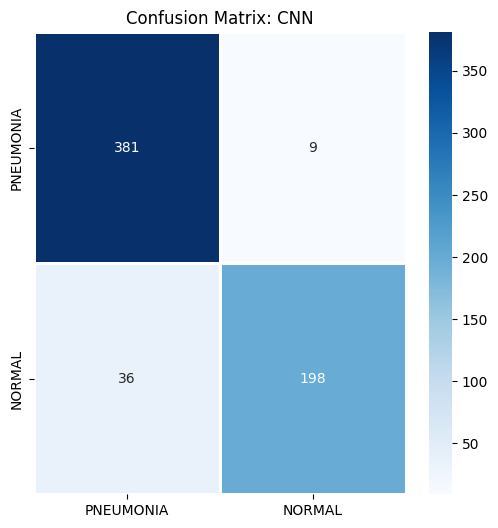

In [15]:
# Confusion Matrix for CNN
cm_cnn = confusion_matrix(y_test, cnn_preds)
cm_cnn_df = pd.DataFrame(cm_cnn, index=labels, columns=labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm_cnn_df, annot=True, fmt='d', cmap='Blues', linewidths=1)
plt.title('Confusion Matrix: CNN')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


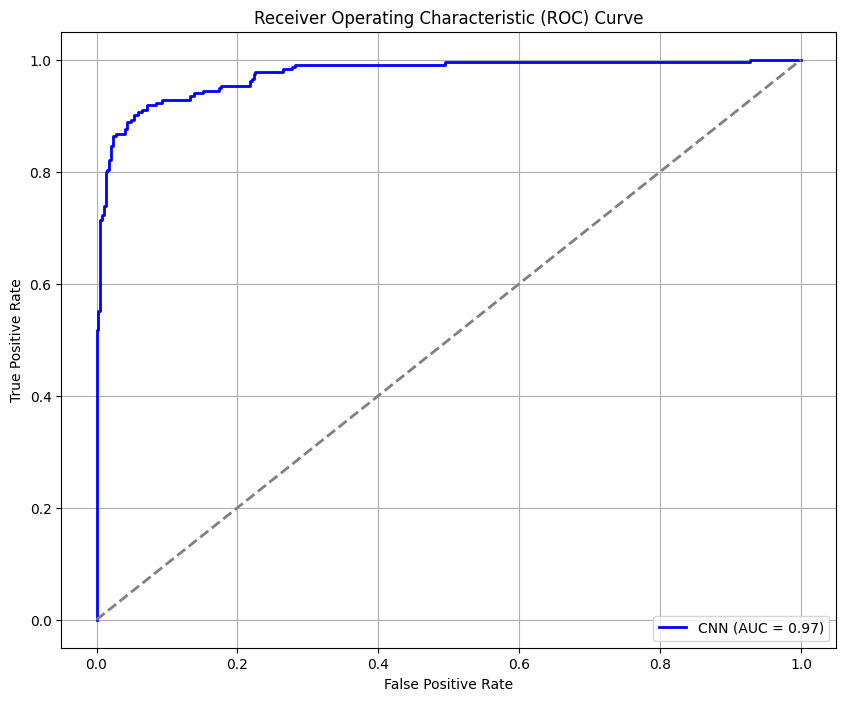

In [16]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer


#%%

# Compute ROC Curve and AUC for CNN (using flattened predictions)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, model.predict(x_test).flatten())
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)
# Plot ROC Curve for all models
plt.figure(figsize=(10, 8))

# Plot ROC curve for CNN
plt.plot(fpr_cnn, tpr_cnn, color='blue', lw=2, label=f'CNN (AUC = {roc_auc_cnn:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)

# Customize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [19]:
# Save the CNN model (Keras)
model.save('/home/silver/Pneumonia-Detection-using-CNN/models/cnn_model.keras')

print("CNN model saved successfully.")

CNN model saved successfully.
